In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

In [2]:
data = pd.read_csv("Workshop_Backtest.csv")

In [3]:
def sharpe_ratio(actualReturn, signals):
    assert actualReturn.shape == signals.shape
    dailyReturns = (actualReturn * signals)
    if(dailyReturns.shape[1] > 1):
        dailyReturns = dailyReturns.mean(axis=1)
    return dailyReturns.mean() / dailyReturns.std() * np.sqrt(240)

In [4]:
actual_returns = data[data['datetime'] >= '2017/1/1'].iloc[:, 1:].to_numpy()

# Linear regression

## Window size search

In [5]:
class singleFeatureDataLoader:
    
    def __init__(self, data_series, window_size=20):
        self.x = data_series.iloc[:-1].to_numpy().reshape(-1,1)
        self.y = data_series.iloc[1:].to_numpy().reshape(-1,1)
        self.window_size = window_size
        self._cnt = 0
        
    def __len__(self):
        return len(self.x) - self.window_size
    
    def __getitem__(self, index):
        return self.x[index :index+self.window_size], self.y[index:index+self.window_size]
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._cnt == self.__len__():
            self._cnt = 0
            raise StopIteration
        self._cnt += 1
        return self.__getitem__(self._cnt - 1)

In [ ]:
sharpeRatioForLinearRegression = []
for windowSize in tqdm(range(20, 1000, 10)):
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-windowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    for col_index, col_name in enumerate(bt_data.columns):
        dataloader = singleFeatureDataLoader(bt_data[col_name], window_size=windowSize)
        for i in range(len(dataloader)):
            x, y = dataloader[i]
            model = LinearRegression().fit(x, y)
            test_x = y[-1].reshape(-1,1)
            signals[i, col_index] = model.predict(test_x)
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForLinearRegression.append(sharpe_ratio(actual_returns, signals))

  2%|▉                                           | 2/98 [00:12<09:53,  6.19s/it]

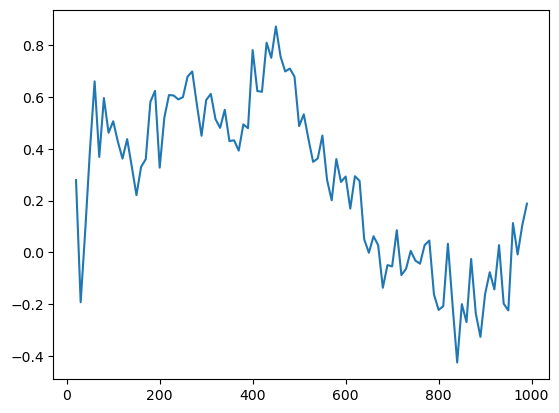

In [8]:
plt.plot([i for i in range(20, 1000, 10)], sharpeRatioForLinearRegression)

In [9]:
print(f"Best window size is: {[i for i in range(20, 1000, 10)][np.argmax(sharpeRatioForLinearRegression)]}")

Best window size is: 450


In [14]:
sharpeRatioForLinearRegression_finerRange = []
for windowSize in tqdm(range(440, 460)):
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-windowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    for col_index, col_name in enumerate(bt_data.columns):
        dataloader = singleFeatureDataLoader(bt_data[col_name], window_size=windowSize)
        for i in range(len(dataloader)):
            x, y = dataloader[i]
            model = LinearRegression().fit(x, y)
            test_x = y[-1].reshape(-1,1)
            signals[i, col_index] = model.predict(test_x)
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForLinearRegression_finerRange.append(sharpe_ratio(actual_returns, signals))

100%|███████████████████████████████████████████| 20/20 [02:16<00:00,  6.82s/it]


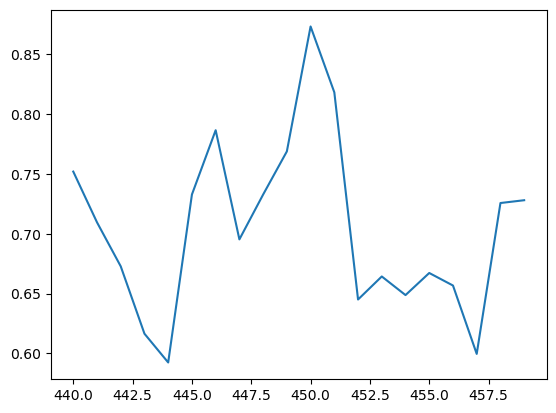

In [15]:
plt.plot([i for i in range(440, 460)], sharpeRatioForLinearRegression_finerRange)

In [19]:
bestWindowSize = [i for i in range(440, 460)][np.argmax(sharpeRatioForLinearRegression_finerRange)]
print(f"Best window size is: {bestWindowSize}")
print(f"Best sharpe is {np.max(sharpeRatioForLinearRegression_finerRange)}")

Best window size is: 450
Best sharpe is 0.8733128113982509


In [6]:
bestWindowSize = 450

## Extend the feature dimension

In [105]:
class DataLoaderV01:
    
    def __init__(self, data_series, window_size=21, feature_size=10):
        self.x = data_series.iloc[:-1].to_numpy().reshape(-1,1)
        self.y = data_series.iloc[feature_size:].to_numpy().reshape(-1,1)
        self.window_size = window_size
        self.feature_size = feature_size
        self.sample_number_per_window = window_size - feature_size + 1
        self._cnt = 0
        
    def __len__(self):
        return len(self.y) - self.window_size
    
    def __getitem__(self, index):
        x_mat = np.zeros((self.sample_number_per_window, self.feature_size)) # (9, 10)
        y_mat = np.zeros((self.sample_number_per_window,1)).reshape(-1,1)
        for i in range(self.sample_number_per_window):
            x_mat[i] = self.x[index + i :index+i+self.feature_size].T
            y_mat[i] = self.y[index + i]
        return x_mat, y_mat
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._cnt == self.__len__():
            self._cnt = 0
            raise StopIteration
        self._cnt += 1
        return self.__getitem__(self._cnt - 1)

In [106]:
sharpeRatioForLinearRegression_featureDimension = []
for featureDim in tqdm(range(1, 51, 10)):
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    for col_index, col_name in enumerate(bt_data.columns):
        dataloader = DataLoaderV01(bt_data[col_name], window_size=bestWindowSize, feature_size=featureDim)
        for i in range(len(dataloader)):
            x, y = dataloader[i]
            model = LinearRegression().fit(x, y)
            signals[i, col_index] = model.predict(y[-featureDim:].reshape(1, -1))
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForLinearRegression_featureDimension.append(sharpe_ratio(actual_returns, signals))

100%|█████████████████████████████████████████████| 5/5 [02:12<00:00, 26.49s/it]


In [107]:
sharpeRatioForLinearRegression_featureDimension

[0.8733128113982509,
 -0.05959328101937293,
 0.07409764738063512,
 0.584366502147363,
 0.10057565676234737]

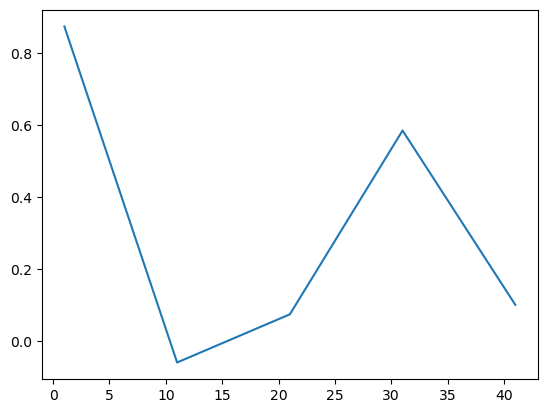

In [108]:
plt.plot([i for i in range(1, 51, 10)], sharpeRatioForLinearRegression_featureDimension)

In [109]:
bestFeatureDim = [i for i in range(1, 51, 10)][np.argmax(sharpeRatioForLinearRegression_featureDimension)]
print(f"Best window size is: {bestFeatureDim}")
print(f"Best sharpe is {np.max(sharpeRatioForLinearRegression_featureDimension)}")

Best window size is: 1
Best sharpe is 0.8733128113982509


## include other column

In [123]:
class DataLoaderV2:
    
    def __init__(self, data_df, window_size=21, feature_size=1, include_other_column=False):
        self.x = data_df.iloc[:-1,:].to_numpy()
        self.column_num = len(data_df.columns)
        self.y = data_df.iloc[feature_size:, :].to_numpy()
        self.window_size = window_size
        self.feature_size = feature_size
        self.include_other_column = include_other_column
        self.sample_number_per_window = window_size - feature_size + 1
        self._cnt = 0
        
    def __len__(self):
        return len(self.y) - self.window_size
    
    def __getitem__(self, index, column_index):
        if self.include_other_column:
            if self.feature_size > 1:
                x_mat = np.zeros((self.sample_number_per_window,self.column_num,self.feature_size))
                y_mat = np.zeros((self.sample_number_per_window,1))
                
                for i in range(self.sample_number_per_window):
                    x_mat[i] = self.x[index+i:index+i+self.feature_size, :].T
                    y_mat[i] = self.y[index + i, column_index]
                return x_mat, y_mat
            else:
                x_mat = np.zeros((self.sample_number_per_window, self.column_num))
                y_mat = np.zeros((self.sample_number_per_window,1))
                
                for i in range(self.sample_number_per_window):
                    x_mat[i] = self.x[index+i, :].T
                    y_mat[i] = self.y[index + i, column_index]
                return x_mat, y_mat
            
        else:
            x_mat = np.zeros((self.sample_number_per_window, self.feature_size)) # (9, 10)
            y_mat = np.zeros((self.sample_number_per_window,1))
            for i in range(self.sample_number_per_window):
                x_mat[i] = self.x[index + i :index+i+self.feature_size, column_index].T
                y_mat[i] = self.y[index + i, column_index]
            return x_mat, y_mat
        
    def get_test(self, index):
        return self.y[index + self.sample_number_per_window - 1:index + self.sample_number_per_window - 1+feature_size]
    
    def get_test_axis_1(self, index, column_index):
        return self.y[index + 1: index+1+self.feature_size, column_index]

In [36]:
bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize-1:,1:]
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
dataloader = DataLoaderV2(bt_data, window_size=bestWindowSize, feature_size=1, include_other_column=True)
for col_index, col_name in enumerate(bt_data.columns):
    for i in range(len(dataloader)):
        x, y = dataloader.__getitem__(i, col_index)
        model = LinearRegression().fit(x, y)
        signals[i, col_index] = model.predict(dataloader.get_test(i).reshape(1,-1))
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

0.058127204051890105

## Regularization

### L2

In [11]:
sharpeRatioForLinearRegression_L2 = []
for _alpha in tqdm(range(1, 50, 1)):
    alpha = _alpha/10.
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    for col_index, col_name in enumerate(bt_data.columns):
        dataloader = singleFeatureDataLoader(bt_data[col_name], window_size=bestWindowSize)
        for i in range(len(dataloader)):
            x, y = dataloader[i]
            model = Ridge(alpha=alpha).fit(x, y)
            test_x = y[-1].reshape(-1,1)
            signals[i, col_index] = model.predict(test_x)
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForLinearRegression_L2.append(sharpe_ratio(actual_returns, signals))

100%|███████████████████████████████████████████| 49/49 [03:54<00:00,  4.79s/it]


Best alpha for Ridge size is: 0.1
Best sharpe is 0.8432307051025795


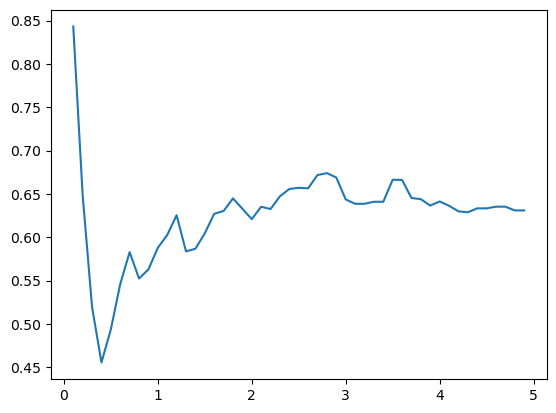

In [12]:
plt.plot([i/10. for i in range(1, 50, 1)], sharpeRatioForLinearRegression_L2)
bestAlpha_ridge = [i/10. for i in range(1, 50, 1)][np.argmax(sharpeRatioForLinearRegression_L2)]
print(f"Best alpha for Ridge size is: {bestAlpha_ridge}")
print(f"Best sharpe is {np.max(sharpeRatioForLinearRegression_L2)}")

### L1

In [15]:
sharpeRatioForLinearRegression_L1 = []
L1_param_set = [i/10. for i in range(1, 50)]
for alpha in tqdm(L1_param_set):
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    for col_index, col_name in enumerate(bt_data.columns):
        dataloader = singleFeatureDataLoader(bt_data[col_name], window_size=bestWindowSize)
        for i in range(len(dataloader)):
            x, y = dataloader[i]
            model = Lasso(alpha=alpha).fit(x, y)
            test_x = y[-1].reshape(-1,1)
            signals[i, col_index] = model.predict(test_x)
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForLinearRegression_L1.append(sharpe_ratio(actual_returns, signals))

100%|███████████████████████████████████████████| 49/49 [04:26<00:00,  5.44s/it]


Best alpha for Ridge size is: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]
Best sharpe is 0.5830140471241282


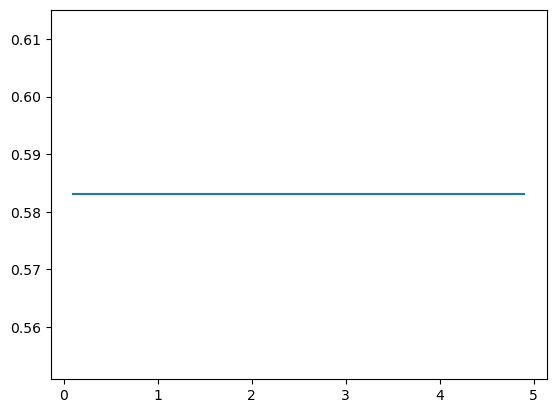

In [16]:
plt.plot(L1_param_set, sharpeRatioForLinearRegression_L1)
bestAlpha_lasso = [L1_param_set][np.argmax(sharpeRatioForLinearRegression_L1)]
print(f"Best alpha for Ridge size is: {bestAlpha_lasso}")
print(f"Best sharpe is {np.max(sharpeRatioForLinearRegression_L1)}")

# SVR

In [17]:
from sklearn import svm

In [43]:
sharpeRatioForSVR = []
kernels = ["linear", 'poly', 'rbf', 'sigmoid']
for kernel in tqdm(kernels):
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    for col_index, col_name in enumerate(bt_data.columns):
        dataloader = singleFeatureDataLoader(bt_data[col_name], window_size=bestWindowSize)
        for i in range(len(dataloader)):
            x, y = dataloader[i]
            y = y.reshape(-1)
            model = svm.SVR(kernel=kernel).fit(x, y)
            test_x = y[-1].reshape(-1,1)
            signals[i, col_index] = model.predict(test_x)
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForSVR.append(sharpe_ratio(actual_returns, signals))

100%|█████████████████████████████████████████████| 4/4 [00:18<00:00,  4.53s/it]


Best alpha for Ridge size is: ['linear', 'poly', 'rbf', 'sigmoid']
Best sharpe is -0.7026920590316471


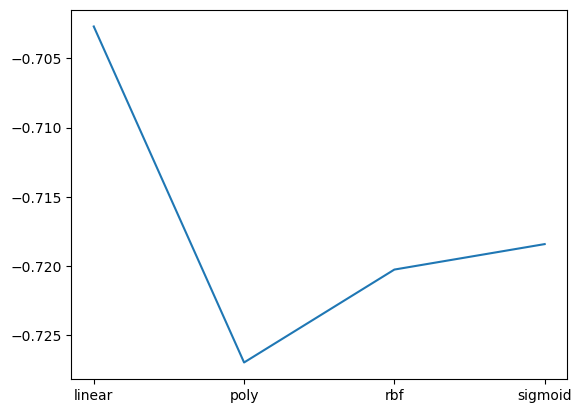

In [44]:
plt.plot(kernels, sharpeRatioForSVR)
bestKernel = [kernels][np.argmax(sharpeRatioForSVR)]
print(f"Best alpha for Ridge size is: {kernels}")
print(f"Best sharpe is {np.max(sharpeRatioForSVR)}")

## Window size

In [100]:
sharpeRatioForSVR_windowSize = {}
window_size = [i for i in range(20, 500, 10)]
kernels = ["linear", 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    sharpeRatioForSVR_windowSize[kernel] = []
    for wSize in tqdm(window_size):
        bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-wSize-1:,1:]
        signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
        for col_index, col_name in enumerate(bt_data.columns):
            dataloader = singleFeatureDataLoader(bt_data[col_name], window_size=wSize)
            for i in range(len(dataloader)):
                x, y = dataloader[i]
                y = y.reshape(-1)
                model = svm.SVR(kernel=kernel).fit(x, y)
                test_x = y[-1].reshape(-1,1)
                signals[i, col_index] = model.predict(test_x)
        signals = np.where(signals > 0, 1, -1)
        sharpeRatioForSVR_windowSize[kernel].append(sharpe_ratio(actual_returns, signals))

100%|███████████████████████████████████████████| 48/48 [03:24<00:00,  4.27s/it]


Best window size for linear kernel is: 30
Best sharpe is 0.8067817416265679
Best window size for poly kernel is: 30
Best sharpe is 0.8067817416265679
Best window size for rbf kernel is: 30
Best sharpe is 0.8067817416265679
Best window size for sigmoid kernel is: 30
Best sharpe is 0.8067817416265679


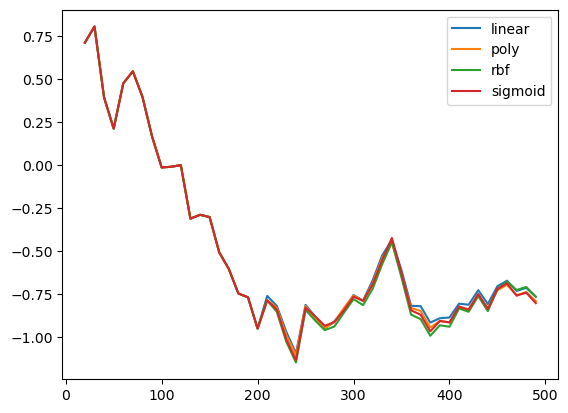

In [101]:
bestWindowSize_SVR = {}
for k in kernels:
    perf = sharpeRatioForSVR_windowSize[k]
    plt.plot(window_size, perf, label=k)
    bestWindowSize_SVR[k] = window_size[np.argmax(perf)]
    print(f"Best window size for {k} kernel is: {bestWindowSize_SVR[k]}")
    print(f"Best sharpe is {np.max(perf)}")
plt.legend()

## Feature dimension

In [122]:
bestWindowSize_SVR = 30

In [115]:
sharpeRatioForSVR_featureDim = {}
featureSizes = [i for i in range(21, 30, 1)]
for kernel in kernels:
    sharpeRatioForSVR_featureDim[kernel] = []
    for fSize in tqdm(featureSizes):
        bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize_SVR-1:,1:]
        signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
        dataloader = DataLoaderV2(bt_data ,feature_size=fSize, window_size=bestWindowSize_SVR)
        for col_index, col_name in enumerate(bt_data.columns):
            for i in range(len(dataloader)):
                x, y = dataloader.__getitem__(i, col_index)
                y = y.reshape(-1)
                model = svm.SVR(kernel=kernel).fit(x, y)
                test_x = dataloader.get_test_axis_1(i, col_index).reshape(1, -1)
                signals[i, col_index] = model.predict(test_x)
        signals = np.where(signals > 0, 1, -1)
        sharpeRatioForSVR_featureDim[kernel].append(sharpe_ratio(actual_returns, signals))

100%|█████████████████████████████████████████████| 9/9 [00:34<00:00,  3.82s/it]


Best feature dim for linear kernel is: 29
Best sharpe is 1.3518256194958702
Best feature dim for poly kernel is: 29
Best sharpe is 1.3518256194958702
Best feature dim for rbf kernel is: 29
Best sharpe is 1.3518256194958702
Best feature dim for sigmoid kernel is: 29
Best sharpe is 1.3518256194958702


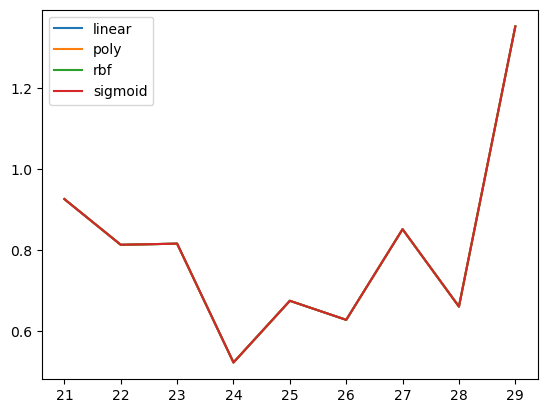

In [116]:
bestFeatureDim_SVR = {}
for k in kernels:
    perf = sharpeRatioForSVR_featureDim[k]
    plt.plot(featureSizes, perf, label=k)
    bestFeatureDim_SVR[k] = featureSizes[np.argmax(perf)]
    print(f"Best feature dim for {k} kernel is: {bestFeatureDim_SVR[k]}")
    print(f"Best sharpe is {np.max(perf)}")
plt.legend()

In [ ]:
sharpeRatioForSVR_windowsize_t1 = []
featureSize_t1 = 29
windowSize_t1 = [i for i in range(30, 200, 10)]
kernel = 'linear'
for windowSize in tqdm(windowSize_t1):
    bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-windowSize-1:,1:]
    signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
    dataloader = DataLoaderV2(bt_data ,feature_size=featureSize_t1, window_size=windowSize)
    for col_index, col_name in enumerate(bt_data.columns):
        for i in range(len(dataloader)):
            x, y = dataloader.__getitem__(i, col_index)
            y = y.reshape(-1)
            model = svm.SVR(kernel=kernel).fit(x, y)
            test_x = dataloader.get_test_axis_1(i, col_index).reshape(1, -1)
            signals[i, col_index] = model.predict(test_x)
    signals = np.where(signals > 0, 1, -1)
    sharpeRatioForSVR_windowsize_t1.append(sharpe_ratio(actual_returns, signals))

Best window size for 29D is: 30
Best sharpe is 1.3518256194958702


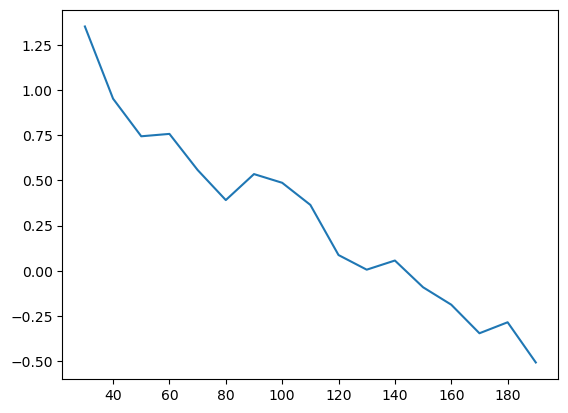

In [120]:
plt.plot(windowSize_t1, sharpeRatioForSVR_windowsize_t1)
bestWindowSize_29D = windowSize_t1[np.argmax(sharpeRatioForSVR_windowsize_t1)]
print(f"Best window size for 29D is: {bestWindowSize_29D}")
print(f"Best sharpe is {np.max(sharpeRatioForSVR_windowsize_t1)}")

In [125]:
bestFeatureDim_SVR = 29

## Regularization

In [128]:
sharpeRatioForSVR_regularization = {}
kernels = ["linear", 'poly', 'rbf', 'sigmoid']
c_candidate = [i/10. for i in range(1, 6)]
for k in kernels:
    sharpeRatioForSVR_regularization[k] = []
    for c in tqdm(c_candidate):
        bt_data = data.iloc[data[data['datetime'] >= '2017/1/1'].iloc[0].name-bestWindowSize_SVR-1:,1:]
        signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
        dataloader = DataLoaderV2(bt_data ,feature_size=bestFeatureDim_SVR, window_size=bestWindowSize_SVR)
        for col_index, col_name in enumerate(bt_data.columns):
            for i in range(len(dataloader)):
                x, y = dataloader.__getitem__(i, col_index)
                y = y.reshape(-1)
                model = svm.SVR(kernel=kernel, C=c).fit(x, y)
                test_x = dataloader.get_test_axis_1(i, col_index).reshape(1, -1)
                signals[i, col_index] = model.predict(test_x)
        signals = np.where(signals > 0, 1, -1)
        sharpeRatioForSVR_regularization[k].append(sharpe_ratio(actual_returns, signals))

100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.67s/it]


Best C for linear kernel is: 0.1
Best sharpe is 1.3518256194958702
Best C for poly kernel is: 0.1
Best sharpe is 1.3518256194958702
Best C for rbf kernel is: 0.1
Best sharpe is 1.3518256194958702
Best C for sigmoid kernel is: 0.1
Best sharpe is 1.3518256194958702


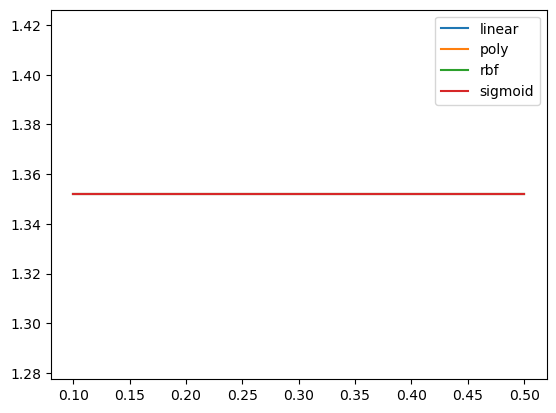

In [130]:
for k in kernels:
    perf = sharpeRatioForSVR_regularization[k]
    plt.plot(c_candidate, perf, label=k)
    best_c = c_candidate[np.argmax(perf)]
    print(f"Best C for {k} kernel is: {best_c}")
    print(f"Best sharpe is {np.max(perf)}")
plt.legend()